
## Sarcasm Detection
#### Description



In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## 1. Read and Visualizing the data

In [2]:
data = pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Number of rows and columns: {data.shape}')
display(data.head())

Number of rows and columns: (26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Analysing the Distribution of Training dataset

Sarcastic count: 11724 in percentage :  44.0%
Non Sarcastic count: 14985 in percentage : 56.0%


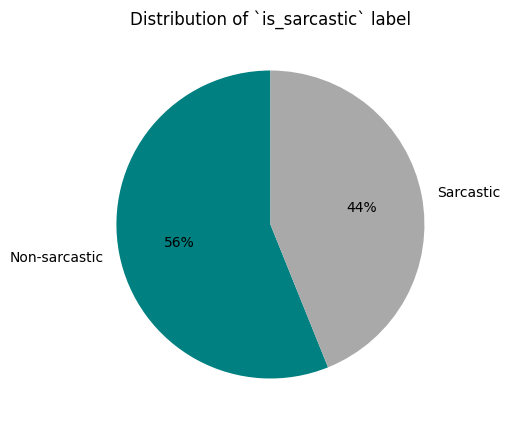

In [3]:
import matplotlib.pyplot as plt

# Your existing code for count and percentage calculation
print(f'Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} in percentage :  {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Non Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} in percentage : {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

# Plotting the pie chart
plt.figure(figsize=(5, 5))
labels = ['Non-sarcastic', 'Sarcastic']
sizes = data['is_sarcastic'].value_counts()
colors = ['#008080', '#A9A9A9']

plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: f'{p:.0f}%', startangle=90)
plt.title('Distribution of `is_sarcastic` label')
plt.show()


# 2. Retain relevant columns

In [4]:
#drop the column article_link
data.drop('article_link', axis = 1, inplace = True)

# 3. Get length of each sentence

In [5]:
lengths = data['headline'].str.len()
lengths

0        78
1        84
2        79
3        84
4        64
         ..
26704    36
26705    23
26706    21
26707    60
26708    33
Name: headline, Length: 26709, dtype: int64

In [6]:
data['headline'][1]

"the 'roseanne' revival catches up to our thorny political mood, for better and worse"

In [7]:
lengths[1]

84

In [8]:
lengths.min()

7

In [9]:
lengths.max()

254

# 4. Define parameters

In [10]:
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [11]:
replace_words = {"ain't": "am not", "aren't": "are not", "can't": "cannot",
         "can't've": "cannot have", "'cause": "because",
         "could've": "could have", "couldn't": "could not",
         "couldn't've": "could not have", "didn't": "did not",
         "doesn't": "does not", "don't": "do not", "hadn't": "had not",
         "hadn't've": "had not have", "hasn't": "has not",
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
         "he'll": "he will", "he'll've": "he will have",
         "he's": "he is", "how'd": "how did",
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
         "I'll've": "I will have", "I'm": "I am", "I've": "I have",
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
         "it'll": "it will", "it'll've": "it will have", "it's": "it is",
         "let's": "let us", "ma'am": "madam", "mayn't": "may not",
         "might've": "might have", "mightn't": "might not",
         "mightn't've": "might not have", "must've": "must have",
         "mustn't": "must not", "mustn't've": "must not have",
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not",
         "oughtn't've": "ought not have", "shan't": "shall not",
         "sha'n't": "shall not", "shan't've": "shall not have",
         "she'd": "she would", "she'd've": "she would have",
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have",
         "shouldn't": "should not", "shouldn't've": "should not have",
         "so've": "so have", "so's": "so is",
         "that'd": "that had", "that'd've": "that would have",
         "that's": "that that is", "there'd": "there would",
         "there'd've": "there would have", "there's": "there is",
         "they'd": "they would", "they'd've": "they would have",
         "they'll": "they will", "they'll've": "they will have",
         "they're": "they are", "they've": "they have",
         "to've": "to have", "wasn't": "was not", "we'd": "we would",
         "we'd've": "we would have", "we'll": "we will",
         "we'll've": "we will have", "we're": "we are",
         "we've": "we have", "weren't": "were not",
         "what'll": "what will", "what'll've": "what will have",
         "what're": "what are", "what's": "what is",
         "what've": "what have", "when's": "when is",
         "when've": "when have", "where'd": "where did",
         "where's": "where is", "where've": "where have",
         "who'll": "who will", "who'll've": "who will have",
         "who's": "who is", "who've": "who have",
         "why's": "why is", "why've": "why have", "will've": "will have",
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not",
         "wouldn't've": "would not have", "y'all": "you all",
         "y'all'd": "you all would", "y'all'd've": "you all would have",
         "y'all're": "you all are", "y'all've": "you all have",
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have",
         "you're": "you are", "you've": "you have"}

In [12]:
#Replace the contracted words
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in replace_words.keys():
            cleaned_headlines.append(replace_words[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

In [13]:
#Remove the punctuation

punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuations))

In [14]:
# Apply lemmatization
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

In [15]:
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40,
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150,
                          mask = mask, collocations = False)
    wordcloud.generate(str(text))

    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(title, fontdict = {'size': title_size, 'color': 'black',
                               'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

In [16]:
import re
print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replace the contracted words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))



Converting headlines to lower case
Replace the contracted words
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words


In [18]:
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Length of line ranges from', data['line_length'].min(), 'to', data['line_length'].max())
print('Number of words ranges from', data['nb_words'].min(), 'to', data['nb_words'].max())

Length of line ranges from 7 to 241
Number of words ranges from 2 to 39


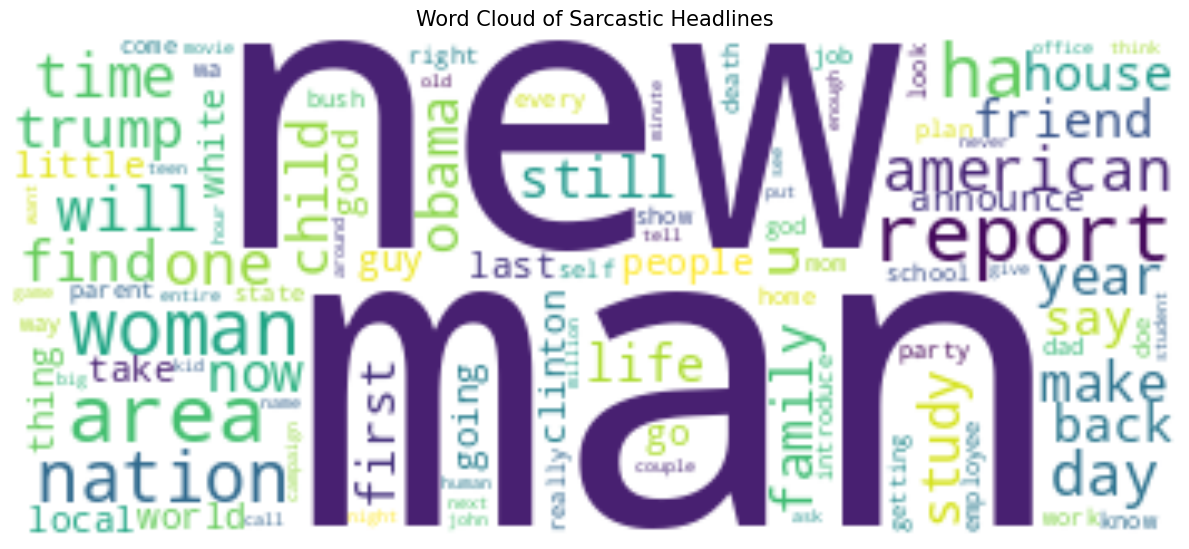

In [19]:
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

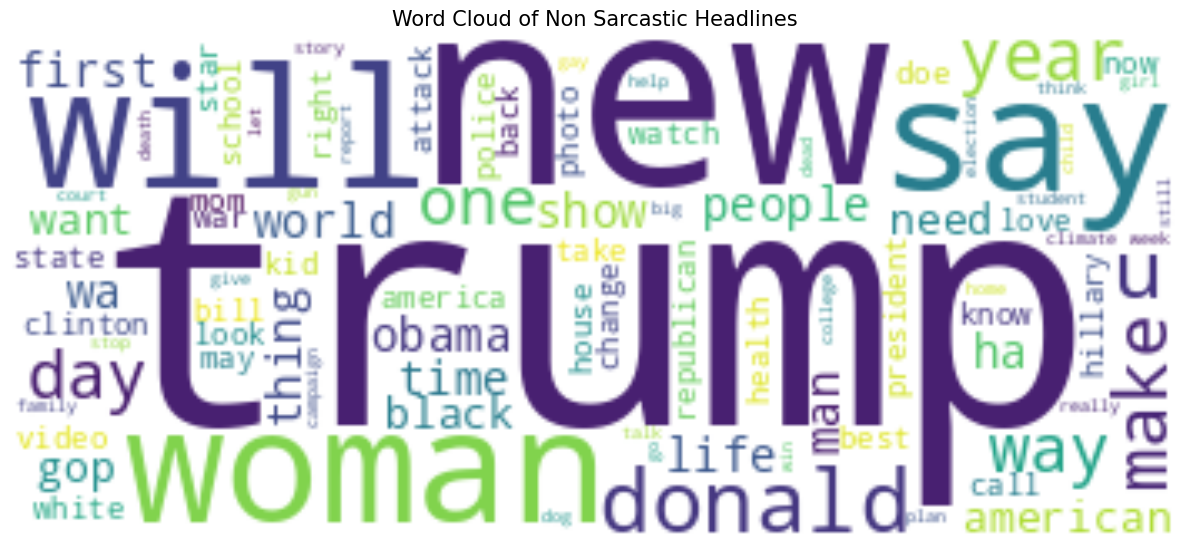

In [20]:
non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Non Sarcastic Headlines')

In [21]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 50 #50

In [22]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [23]:
train_data = tokenizer.texts_to_sequences(data['cleaned_headline'])
train_data = pad_sequences(train_data, maxlen = maxlen)
train_labels = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(train_data)}')
print(f'Number of Labels: {len(train_labels)}')
print(f'\nFirst headline:\n{train_data[0]}\n\nLabel of the first headline: {train_labels[0]}')


Number of Samples: 26709
Number of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  327  686 2924 1254   54  291  107 1915    6 2014 3610]

Label of the first headline: 0


In [24]:
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 24962


In [25]:
f = open("glove.6B.50d.txt", encoding="utf8")
embeddings = {}
for o in f:
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [26]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

68761

### Define and compile a Bidirectional LSTM model

In [27]:
feature_train, feature_test, label_train, label_test = train_test_split(train_data, train_labels, test_size = 0.2, random_state = random_state, shuffle = True)

print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(feature_train)))}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(feature_test)))}')


Number of unique words in training dataset: 9959
Number of unique words in test dataset: 7397


In [28]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5)
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 50)            500050    
                                                                 
 bidirectional (Bidirection  (None, 39, 256)           183296    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [29]:
batch_size = 100
epochs = 6

h = model.fit(feature_train, label_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 1: val_loss improved from inf to 0.56651, saving model to sarcasm_detector.h5
171/171 - 13s - loss: 0.6491 - accuracy: 0.6077 - val_loss: 0.5665 - val_accuracy: 0.7202 - lr: 0.0010 - 13s/epoch - 76ms/step
Epoch 2/6

Epoch 2: val_loss improved from 0.56651 to 0.47517, saving model to sarcasm_detector.h5
171/171 - 3s - loss: 0.5377 - accuracy: 0.7443 - val_loss: 0.4752 - val_accuracy: 0.7740 - lr: 0.0010 - 3s/epoch - 18ms/step
Epoch 3/6

Epoch 3: val_loss improved from 0.47517 to 0.42551, saving model to sarcasm_detector.h5
171/171 - 3s - loss: 0.4711 - accuracy: 0.7835 - val_loss: 0.4255 - val_accuracy: 0.8016 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 4/6

Epoch 4: val_loss improved from 0.42551 to 0.39666, saving model to sarcasm_detector.h5
171/171 - 4s - loss: 0.4313 - accuracy: 0.8058 - val_loss: 0.3967 - val_accuracy: 0.8168 - lr: 0.0010 - 4s/epoch - 21ms/step
Epoch 5/6

Epoch 5: val_loss improved from 0.39666 to 0.38953, saving model to sarcasm_detector.h5
171/171

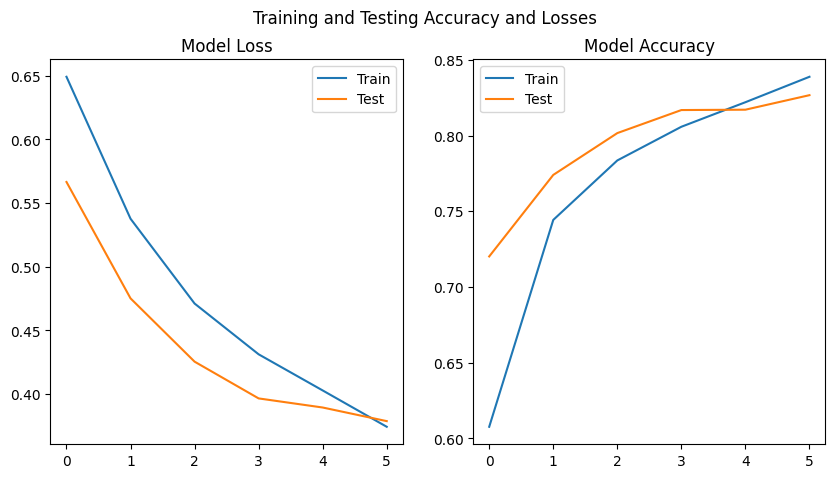

In [30]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize = (10,5))
figure.suptitle('Training and Testing Accuracy and Losses')

axis1.plot(h.history['loss'], label = 'Train')
axis1.plot(h.history['val_loss'], label = 'Test')
axis1.set_title('Model Loss')
axis1.legend(['Train', 'Test'])

axis2.plot(h.history['accuracy'], label = 'Train')
axis2.plot(h.history['val_accuracy'], label = 'Test')
axis2.set_title('Model Accuracy')
axis2.legend(['Train', 'Test'])

plt.show()

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(feature_test, label_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 83.0


In [32]:
model.save('sarcastic_detection_model.h5')

In [33]:
predicted = (model.predict(feature_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(predicted, label_test)}')

167/167 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      3225
           1       0.76      0.84      0.79      2117

    accuracy                           0.83      5342
   macro avg       0.82      0.83      0.82      5342
weighted avg       0.83      0.83      0.83      5342



Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2652,344
Sarcastic,573,1773


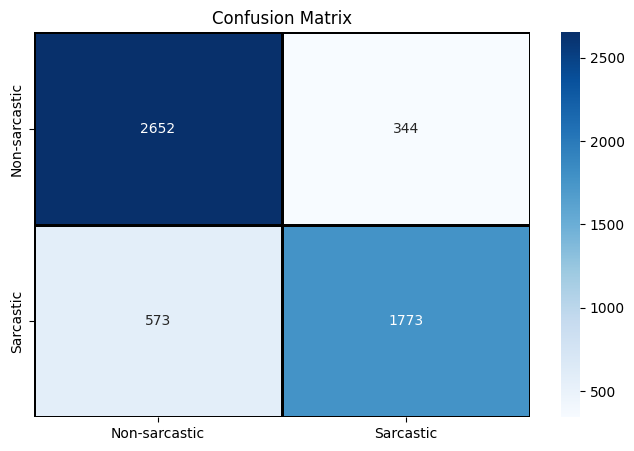

In [34]:
print('Confusion Matrix')
matrix = confusion_matrix(label_test, predicted)
matrix = pd.DataFrame(matrix , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(matrix);

plt.figure(figsize = (8, 5))
_ = sns.heatmap(matrix, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True,
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'],
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')


### BERT Model

In [45]:
from transformers import DistilBertTokenizer

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', lower=True)

# Save the vocabulary to a file
tokenizer.save_pretrained('./')

# Now you can initialize the BertWordPieceTokenizer
from tokenizers import BertWordPieceTokenizer

fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)


In [46]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)  # Adjusted line
    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)


In [47]:
bert_train_data = fast_encode(data['cleaned_headline'].values, fast_tokenizer, maxlen=400)
bert_train_label = data['is_sarcastic'].values

bert_feature_train,bert_feature_test,bert_label_train,bert_label_test = train_test_split(bert_train_data,bert_train_label, test_size=0.2, random_state=42)


In [48]:
import transformers
from keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam

def build_model(transformer, max_len=400):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Load DistilBERT
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model = build_model(transformer_layer, max_len=400)

# Model summary
print(model.summary())


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 400)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   66362880  
 stilBertModel)              hidden_state=(None, 400             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 769   

In [49]:
history = model.fit(bert_feature_train, bert_label_train, batch_size=32, validation_data=(bert_feature_test, bert_label_test), epochs=3)


Epoch 1/3
668/668 [==============================] - 1064s 2s/step - loss: 0.7139 - accuracy: 0.5354 - val_loss: 0.6938 - val_accuracy: 0.5608
Epoch 2/3
668/668 [==============================] - 1037s 2s/step - loss: 0.6907 - accuracy: 0.5448 - val_loss: 0.6858 - val_accuracy: 0.5608
Epoch 3/3
668/668 [==============================] - 1037s 2s/step - loss: 0.6973 - accuracy: 0.5478 - val_loss: 0.6861 - val_accuracy: 0.5608


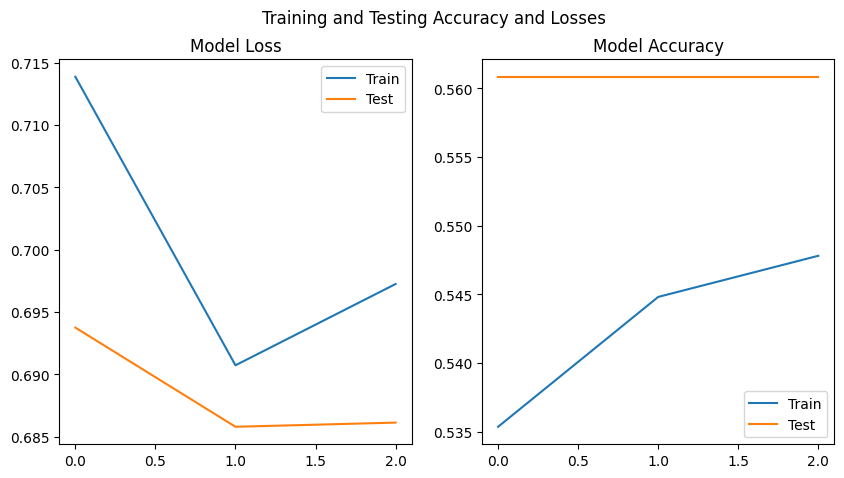

In [50]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize = (10,5))
figure.suptitle('Training and Testing Accuracy and Losses')

axis1.plot(history.history['loss'], label = 'Train')
axis1.plot(history.history['val_loss'], label = 'Test')
axis1.set_title('Model Loss')
axis1.legend(['Train', 'Test'])

axis2.plot(history.history['accuracy'], label = 'Train')
axis2.plot(history.history['val_accuracy'], label = 'Test')
axis2.set_title('Model Accuracy')
axis2.legend(['Train', 'Test'])

plt.show()

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(bert_feature_test, bert_label_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 56.0


In [52]:
bert_pred = model.predict(bert_feature_test)
bert_prediction = np.round(bert_pred).astype(int)

167/167 [==============================] - 81s 474ms/step


In [54]:
print(classification_report(bert_label_test, bert_prediction))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      2996
           1       0.00      0.00      0.00      2346

    accuracy                           0.56      5342
   macro avg       0.28      0.50      0.36      5342
weighted avg       0.31      0.56      0.40      5342



In conclusion, the sarcasm detection task involved a series of preprocessing steps, including handling contractions, converting text to lowercase, lemmatization, and punctuation removal. These processed texts were then embedded using the GloVe model. The experimental phase featured the training of two models: a Bidirectional LSTM model yielded a promising 83% accuracy, while the BERT pre-trained model achieved a reasonable 56% accuracy in sarcasm detection.